# Diagramación de una Chacra para Forestería Análoga

### © Equipo I+D SomosAZUCAR - Bajo licencia AGPLv3

```
Diagramador de Planos para Forestería Análoga
Copyright (C) 2015 Sebastian Silva

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
# Bibliotecas utilizadas para confeccionar el mapa
%matplotlib inline
import matplotlib.pyplot as plt
from shapely import geometry
import numpy as np
import pandas as pd
import random
import mpld3

## 1.- DATOS INICIALES
### © Arbio - licencia por definir

La base de datos consiste en una lista de especies, cantidades, diámetro, y características.

In [4]:
plantas = pd.read_csv("db.csv") ## Es una base


In [5]:
consolidado = pd.DataFrame({'especies':plantas.groupby('estrato').size(), 'individuos':plantas.groupby('estrato')['cantidad'].sum()})
pd.concat([consolidado,pd.DataFrame(consolidado.sum(axis=0),columns=['Total']).T])


,especies,individuos
estrato,,
1,2,1472
2,5,310
3,10,160
4,7,48
5,1,6
Total,25,1996


## 2.- LINDEROS DE LA CHACRA

Los linderos están definidos como un polígono en metros, desde una de las esquinas.

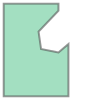

In [9]:
chacra = geometry.Polygon([ [0,0],
                            [0, 93],
                            [55, 93],
                            [55, 86],
                            [35, 65],
                            [37.5, 47.5],
                            [55, 44],
                            [65, 52.5],
                            [65, 0] ])
chacra

In [16]:
lindero_x, lindero_y = chacra.exterior.xy

## 3.- Definir ubicaciones

In [11]:
def punto_aleatorio(poligono):
    (minx, miny, maxx, maxy) = poligono.bounds
    while True:
        p = geometry.Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if poligono.contains(p):
            return(p)

In [12]:
class Planta:
    def __init__(self, poligono, individuo):
        self.posicion = punto_aleatorio(poligono)
        self.idx = individuo[0]
        self.nombre = individuo[1]
        self.cantidad = individuo[2]
        self.diametro = individuo[3]

In [13]:
poblacion = []
for individuo in list(plantas.itertuples()):
    poblacion.append(Planta(chacra, individuo))

In [14]:
planta_x, planta_y, color = [], [], []
for estrato in consolidado.iterrows():
    #print (estrato[1]['individuos'])
    color.append(np.random.rand(3,))
    for planta in range(estrato[1]['individuos']):
        p = punto_aleatorio(chacra)
        planta_x.append(p.x)
        planta_y.append(p.y)
        #x[total], y[total] = p.x, p.y
        #total = total + 1
    #for planta in especie:
    #    print (planta)

## 4.- Graficar el mapa

Empezamos por los linderos de la chacra.

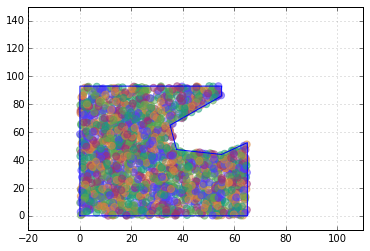

In [15]:
fig = plt.figure()
chacra_x, chacra_y = chacra.exterior.xy
ax = fig.add_subplot(111)
ax.set_ylim(-10,150)
ax.set_xlim(-20,110)
ax.plot(chacra_x, chacra_y)
ax.scatter(planta_x, planta_y, color=color, s=50, alpha=0.5)
ax.grid(color='gray', alpha=0.9)

In [9]:
# Gráfico interactivo
mpld3.display(fig)